# Install Packages

In [1]:
! pip install rasterio
! pip install imageio
! pip install segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ----------------- ---------------------- 1.0/2.4 MB 1.7 MB/s eta 0:00:01
   -------------------------- ------------- 1.6/2.4 MB 2.1 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 2.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=

In [4]:
! pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.0 MB 2.4 MB/s eta 0:00:04
   ------- -------------------------------- 1.8/10.0 MB 2.9 MB/s eta 0:00:03
   ---------- ----------------------------- 2.6/10.0 MB 3.0 MB/s eta 0:00:03
   ----------- ---------------------------- 2.9/10.0 MB 3.3 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.0 MB 2.8 MB/s eta 0:00:03
   ----------------- ---------------------- 4.5/10.0 MB 3.1 MB/s eta 0:00:02
   ----------------------- ---------------- 5.8/10.0 MB 3.4 MB/s eta 0:00:02
   ------------------------- -------------- 6.3/10.0 MB 3.3 MB/s eta 0:00:02
   ----------------------------- ---------- 7.3/10.0 MB 3.4 MB/s eta 0:00:01
   -------------------------------- ------- 8.1/10.0 MB 3.5 MB/s eta 0:00:01
   ---------

# Ignore Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import Packages

In [5]:
import os
import gc
import cv2
import torch
import random
import imageio
import rasterio
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
import tifffile as tiff
import tensorflow as tf
import torch.optim as optim
from tensorflow import keras
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from transformers import SegformerForSemanticSegmentation,AutoModelForImageSegmentation, AutoFeatureExtractor

# Set parameters

In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12  # 12 Channels as per the provided image
BATCH_SIZE = 16
EPOCHS = 50

# Load Data

In [7]:
IMG_HEIGHT = 128
IMG_WIDTH = 128


def load_data(image_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, base_name + '.png')
        image = imageio.imread(image_path)
        label = imageio.imread(label_path)
        
        # Resize images to (128, 128)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)
     

In [8]:
IMAGE_DIR = r"C:\Data Sets\Water-Segmentation\images"
LABEL_DIR = r"C:\Data Sets\Water-Segmentation\labels"

X,  Y = load_data(IMAGE_DIR, LABEL_DIR)
Y = np.expand_dims(Y, axis=-1)

# Normalization

In [9]:
X = X.astype(np.float32)
X[:, :, :, [2, 3, 4]] /= 255.0  #  RGB bands
X[:, :, :, [i for i in range(12) if i not in [2, 3, 4]]] /= 10000.0  #  Rest of bands

# Split Data

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Transfer Learning

In [11]:
pre_model = "facebook/detr-resnet-50-panoptic"

# Load Data

In [12]:
class WaterSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).squeeze(-1).unsqueeze(0)
        return image, mask

In [13]:
BATCH_SIZE = 4

train_dataset = WaterSegmentationDataset(X_train, Y_train)
val_dataset = WaterSegmentationDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Res-Net50 (Pre-Trained Model)

In [14]:
model_resnet = smp.DeepLabV3(encoder_name="resnet50", encoder_weights="imagenet", in_channels=12, classes=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\mehab/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:28<00:00, 3.55MB/s]


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet.to(device)

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


# Garbage Collector (Clear-Up Memory)

In [16]:
gc.collect()
torch.cuda.empty_cache()

# Train Model (Pre-Trained Model)

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)

In [18]:
def train_model(model, optimizer, train_loader, num_epochs=50, save_path='deeplabv3.pth'):
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Save the best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with loss {best_loss:.4f}")

    return model


In [19]:
print("Training Model (DeepLabV3)...")
model1 = train_model(model_resnet, optimizer, train_loader, num_epochs=EPOCHS)

Training Model (DeepLabV3)...
Epoch 1/50, Loss: 0.4909
Best model saved with loss 0.4909
Epoch 2/50, Loss: 0.3942
Best model saved with loss 0.3942
Epoch 3/50, Loss: 0.3328
Best model saved with loss 0.3328
Epoch 4/50, Loss: 0.2893
Best model saved with loss 0.2893
Epoch 5/50, Loss: 0.2539
Best model saved with loss 0.2539
Epoch 6/50, Loss: 0.2470
Best model saved with loss 0.2470
Epoch 7/50, Loss: 0.2198
Best model saved with loss 0.2198
Epoch 8/50, Loss: 0.2087
Best model saved with loss 0.2087
Epoch 9/50, Loss: 0.2065
Best model saved with loss 0.2065
Epoch 10/50, Loss: 0.1899
Best model saved with loss 0.1899
Epoch 11/50, Loss: 0.1696
Best model saved with loss 0.1696
Epoch 12/50, Loss: 0.1608
Best model saved with loss 0.1608
Epoch 13/50, Loss: 0.1499
Best model saved with loss 0.1499
Epoch 14/50, Loss: 0.1496
Best model saved with loss 0.1496
Epoch 15/50, Loss: 0.1667
Epoch 16/50, Loss: 0.1410
Best model saved with loss 0.1410
Epoch 17/50, Loss: 0.1312
Best model saved with loss 

# Evaluating Model (Pre-Trained Model)

In [20]:
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            y_true.extend(masks.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())
    iou = jaccard_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    

In [21]:
evaluate_model(model1, val_loader)

IoU: 0.8292, Precision: 0.9018, Recall: 0.9115, F1-Score: 0.9066


# Prediction (Pre-Trained Model)

Visualizing Model Predictions...


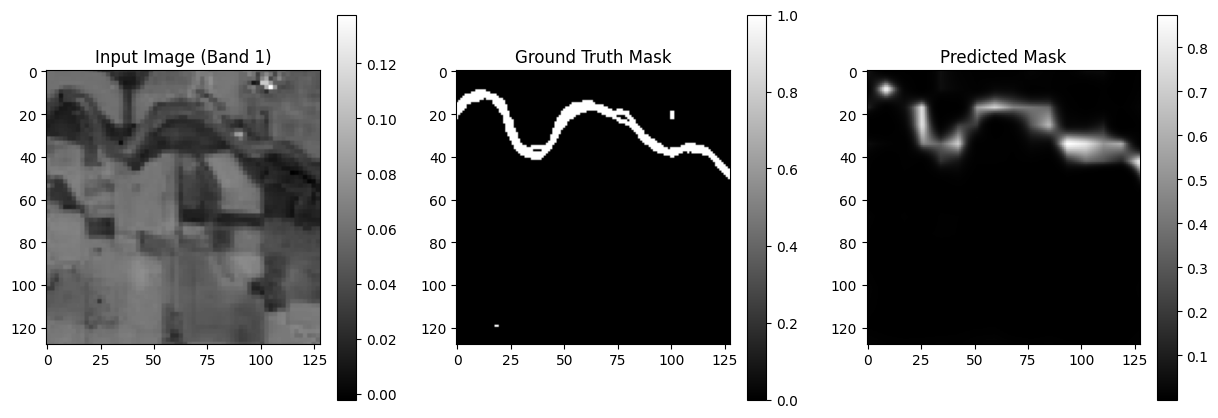

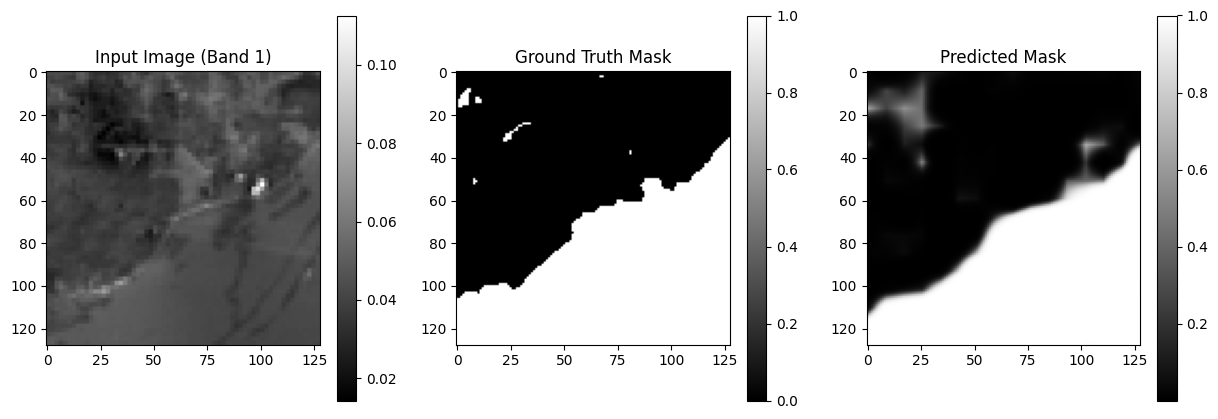

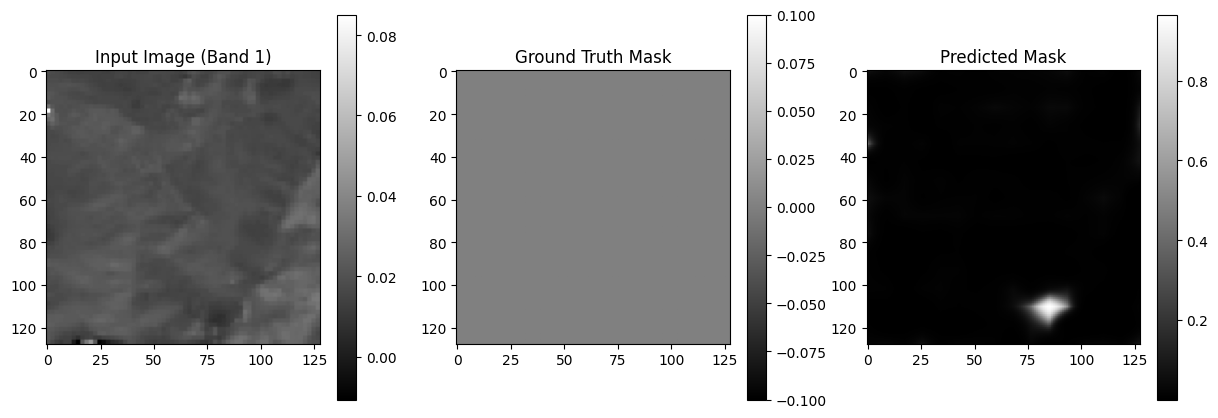

In [22]:
def visualize_predictions(model, X_val, Y_val, num_visualizations=3):
    model.eval()
    with torch.no_grad():
        indices = np.random.choice(len(X_val), num_visualizations, replace=False)
        selected_X = X_val[indices]
        selected_Y = Y_val[indices]
        preds = torch.sigmoid(model(torch.tensor(selected_X, dtype=torch.float32).permute(0, 3, 1, 2).to(device))).cpu().numpy()
    
    for i in range(num_visualizations):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Input Image (Band 1)')
        plt.imshow(selected_X[i, :, :, 0], cmap='gray')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(selected_Y[i, :, :, 0], cmap='gray')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(preds[i, 0, :, :], cmap='gray')
        plt.colorbar()

        plt.show()

# Visualize Results
print("Visualizing Model Predictions...")
visualize_predictions(model1, X_val, Y_val)